# Анализ прибыльности авиарейсов<br />(г. Анапа, зима 2016-2017)
## Власов Д. В. (группа dst-26)

## Загрузка библиотек для работы с данными

In [1]:
!pip install haversine

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import iqr

import datetime as dt

from haversine import haversine, Unit

### Настройка библиотек

In [3]:
pd.set_option('display.encoding', "UTF-8")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# pd.set_option('display.html.border', 2)
# pd.set_option('display.html.table_schema', True)

### Оформление

In [4]:
# from IPython.core.display import display, HTML


# def css_border(x):
#     return ["border-left: 2px solid black" if (i % 2 == 0) else "border-left: 2px solid black" for i, col in enumerate(x)]


# def pd_html(df: pd.DataFrame):
#     return HTML(( df.style.apply(css_border, axis=1).render() ))


# def display_pd_html(df: pd.DataFrame):
#     return display(pd_html(df))

## Подпрограммы работы с данными

### Подпрограммы для графического отображения данных

In [5]:
def get_boxplot(data: pd.DataFrame, column_x, column_y):
    """Рисование диаграммы boxplot для
    колонки column_x по оси абсцисс и колонки column_y по оси ординат.

    Parameters:
        data - общий набор данных, в колонке column которого найдены выбросы
        column_x - колонка с данными, откладываемыми по оси абсцисс
        column_y - колонка с данными, откладываемыми по оси ординат
    
    Returns:
        See description.
    """
    fig, ax = plt.subplots(figsize = (14, 4))

    column_x_values = list(data[column_x].unique())
    column_x_values.sort()
    sns.boxplot(
        x=column_x, y=column_y.name, 
        data=data,
        ax=ax,
        order=column_x_values)

    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column_x)
    plt.show()

## 1. Загрузка сырых данных

### 1.1 Загрузка данных о перелётах из Анапы в зимние месяцы 2017-го года

In [6]:
data_raw = pd.read_csv('../01-database-initial-exploration/initial_raw_dataset_2016_2017.csv')

In [7]:
data_raw.sample(5)

flight_id departure_airport arrival_airport      actual_departure  \
139     136706               AAQ             EGO  2017-01-06T09:30:00Z   
49      136391               AAQ             SVO  2016-12-03T10:08:00Z   
147     136802               AAQ             EGO  2017-02-26T09:32:00Z   
36      136143               AAQ             SVO  2016-12-14T10:06:00Z   
130     136774               AAQ             EGO  2016-12-02T09:27:00Z   

           actual_arrival  departure_delay_mins  arrival_delay_mins  \
139  2017-01-06T10:20:00Z                   5.0                 5.0   
49   2016-12-03T11:48:00Z                   3.0                 3.0   
147  2017-02-26T10:22:00Z                   7.0                 7.0   
36   2016-12-14T11:46:00Z                   1.0                 1.0   
130  2016-12-02T10:17:00Z                   2.0                 2.0   

     tickets_economy  seats_economy  economy_load  tickets_business  \
139               84             85      0.988235                11   
49                97            118      0.822034                10   
147               85             85      1.000000                11   
36                94            118      0.796610                11   
130               81             85      0.952941                12   

     seats_business  business_load  tickets_all  seats  total_load  \
139              12       0.916667           95     97    0.979381   
49               12       0.833333          107    130    0.823077   
147              12       0.916667           96     97    0.989691   
36               12       0.916667          105    130    0.807692   
130              12       1.000000           93     97    0.958763   

     amount_economy  amount_business  amount_all aircraft_code  range  \
139        532200.0         207900.0    740100.0           SU9   3000   
49        1190600.0         366000.0   1556600.0           733   4200   
147        538500.0         207900.0    746400.0           SU9   3000   
36        1151600.0         402600.0   1554200.0           733   4200   
130        513300.0         226800.0    740100.0           SU9   3000   

     departure_airport_latitude  departure_airport_longitude  \
139                   45.002102                    37.347301   
49                    45.002102                    37.347301   
147                   45.002102                    37.347301   
36                    45.002102                    37.347301   
130                   45.002102                    37.347301   

     arrival_airport_latitude  arrival_airport_longitude  
139                 50.643799                  36.590099  
49                  55.972599                  37.414600  
147                 50.643799                  36.590099  
36                  55.972599                  37.414600  
130                 50.643799                  36.590099

### 1.2 Загрузка дополнительных данных по моделям самолётов

In [8]:
data_aircraft = pd.read_csv('../01-database-initial-exploration/aircraft-data.csv')

In [9]:
data_aircraft.sample(2)

aircraft_id aircraft_code        aircraft_name  fuel_g_per_pass_km  \
1            2           SU9  Sukhoi Superjet-100               23.46   
0            1           733       Boeing 737-300               25.00   

   fuel_kg_per_hour  fuel_tank_volume_L  
1              1800               15805  
0              2400               23830

### 1.3 Загрузка цен для аэропортов<br />(цена на топливо, цена простоя за минуту,..)

<b>Замечание:</b><br />
Цена задержки за минуту рейса при вылете или прилёте судна ($38 - для Boeing 737-800)<br />
взята ориентировочно на основе оценки:<br />
[How much does it cost the airliner per minute when a plane is delayed?](https://www.quora.com/How-much-does-it-cost-the-airliner-per-minute-when-a-plane-is-delayed "How much does it cost the airliner per minute when a plane is delayed?")<br />
Курс доллара США взят примерно равным 60 рублям за 1 доллар для 2017-го года.

<div style="color: gray">
Другой вариант: https://www.airlines.org/dataset/per-minute-cost-of-delays-to-u-s-airlines/# .<br />
</div>

In [10]:
data_airport = pd.read_csv('../01-database-initial-exploration/airport-prices.csv')

In [11]:
data_airport.head(3)

year_month airport_code  fuel_price_rubles_per_ton  fuel_value_added_tax  \
0    2017-01          AAQ                      41435                  0.18   
1    2017-02          AAQ                      39553                  0.18   
2    2017-12          AAQ                      47101                  0.18   

   delay_cost_per_minute  
0                   2280  
1                   2280  
2                   2280

In [12]:
data_airport["year_month"] = pd.to_datetime(data_airport["year_month"], format="%Y-%m")

In [13]:
data_airport.head(16)

year_month airport_code  fuel_price_rubles_per_ton  fuel_value_added_tax  \
0  2017-01-01          AAQ                      41435                  0.18   
1  2017-02-01          AAQ                      39553                  0.18   
2  2017-12-01          AAQ                      47101                  0.18   
3  2016-12-01          AAQ                      38867                  0.18   
4  2017-01-01          EGO                      36864                  0.18   
5  2017-02-01          EGO                      36864                  0.18   
6  2017-12-01          EGO                      44068                  0.18   
7  2016-12-01          EGO                      34746                  0.18   
8  2017-01-01          SVO                      36853                  0.18   
9  2017-02-01          SVO                      36853                  0.18   
10 2017-12-01          SVO                      45300                  0.18   
11 2016-12-01          SVO                      36853                  0.18   
12 2017-01-01          NOZ                      36000                  0.18   
13 2017-02-01          NOZ                      36000                  0.18   
14 2017-12-01          NOZ                      46000                  0.18   
15 2016-12-01          NOZ                      36000                  0.18   

    delay_cost_per_minute  
0                    2280  
1                    2280  
2                    2280  
3                    2280  
4                    2280  
5                    2280  
6                    2280  
7                    2280  
8                    2280  
9                    2280  
10                   2280  
11                   2280  
12                   2280  
13                   2280  
14                   2280  
15                   2280

In [14]:
# data_airport.loc[data_airport.loc[:, "fuel_price_rubles_per_ton"].isin(data_airport.loc[:, "fuel_price_rubles_per_ton"].value_counts().index[:5])]

## 2. Добавление дополнительных данных к каждому рейсу

### 2.1 Предобработка колонок с датами и временем вылета/прилёта

In [15]:
data_raw["actual_departure"] = pd.to_datetime(data_raw["actual_departure"], format="%Y-%m-%dT%H:%M:%SZ")
data_raw["actual_arrival"] = pd.to_datetime(data_raw["actual_arrival"], format="%Y-%m-%dT%H:%M:%SZ")

### 2.2 Добавление колонок<br /><i>удельного расхода топлива</i> и<br/><i>часового расхода</i>

In [16]:
data = data_raw.join(data_aircraft.set_index("aircraft_code"), on="aircraft_code")
data.drop(["aircraft_id"], axis=1, inplace=True)
data = data.reindex(
    columns=[
        "flight_id", "departure_airport", "arrival_airport",
        "actual_departure", "actual_arrival", "departure_delay_mins", "arrival_delay_mins",
        "tickets_all", "seats", "total_load", "amount_all",
        "tickets_economy", "seats_economy", "economy_load",
        "tickets_business", "seats_business", "business_load",
        "amount_economy", "amount_business",
        "aircraft_code", "aircraft_name",
        "fuel_g_per_pass_km", "fuel_kg_per_hour", "fuel_tank_volume_L",
        "range",
        "departure_airport_latitude", "departure_airport_longitude",
        "arrival_airport_latitude", "arrival_airport_longitude"
    ]
)

In [17]:
data.sample(5)

flight_id departure_airport arrival_airport    actual_departure  \
162     136389               AAQ             SVO 2017-01-18 10:10:00   
90      136660               AAQ             EGO 2017-02-20 09:26:00   
122     136632               AAQ             EGO 2017-01-07 12:42:00   
125     136249               AAQ             SVO 2017-02-14 10:08:00   
97      136284               AAQ             SVO 2017-02-07 10:07:00   

         actual_arrival  departure_delay_mins  arrival_delay_mins  \
162 2017-01-18 11:50:00                   5.0                 5.0   
90  2017-02-20 10:15:00                   1.0                 0.0   
122 2017-01-07 13:33:00                 197.0               198.0   
125 2017-02-14 11:46:00                   3.0                 1.0   
97  2017-02-07 11:48:00                   2.0                 3.0   

     tickets_all  seats  total_load  amount_all  tickets_economy  \
162          129    130    0.992308   1873800.0              117   
90            87     97    0.896907    677100.0               77   
122           91     97    0.938144    714300.0               80   
125          123    130    0.946154   1800600.0              111   
97           117    130    0.900000   1677400.0              107   

     seats_economy  economy_load  tickets_business  seats_business  \
162            118      0.991525                12              12   
90              85      0.905882                10              12   
122             85      0.941176                11              12   
125            118      0.940678                12              12   
97             118      0.906780                10              12   

     business_load  amount_economy  amount_business aircraft_code  \
162       1.000000       1434600.0         439200.0           733   
90        0.833333        488100.0         189000.0           SU9   
122       0.916667        506400.0         207900.0           SU9   
125       1.000000       1361400.0         439200.0           733   
97        0.833333       1311400.0         366000.0           733   

           aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
162       Boeing 737-300               25.00              2400   
90   Sukhoi Superjet-100               23.46              1800   
122  Sukhoi Superjet-100               23.46              1800   
125       Boeing 737-300               25.00              2400   
97        Boeing 737-300               25.00              2400   

     fuel_tank_volume_L  range  departure_airport_latitude  \
162               23830   4200                   45.002102   
90                15805   3000                   45.002102   
122               15805   3000                   45.002102   
125               23830   4200                   45.002102   
97                23830   4200                   45.002102   

     departure_airport_longitude  arrival_airport_latitude  \
162                    37.347301                 55.972599   
90                     37.347301                 50.643799   
122                    37.347301                 50.643799   
125                    37.347301                 55.972599   
97                     37.347301                 55.972599   

     arrival_airport_longitude  
162                  37.414600  
90                   36.590099  
122                  36.590099  
125                  37.414600  
97                   37.414600

### 2.3 Добавление цен в аэропортах в общую таблицу

In [18]:
# Цена топлива за тонну
data.insert(
    data.columns.get_loc("departure_airport_latitude") - 1, "departure_fuel_price_per_ton", np.nan
)
data.insert(
    data.columns.get_loc("departure_fuel_price_per_ton") + 1, "arrival_fuel_price_per_ton", np.nan
)
# НДС (до 2019-го года НДС был 18%)
data.insert(
    data.columns.get_loc("arrival_fuel_price_per_ton") + 1, "fuel_value_added_tax", np.nan
)
# Стоимость задержки самолёта для аэропорта в минуту
data.insert(
    data.columns.get_loc("fuel_value_added_tax") + 1, "departure_delay_cost_min", np.nan
)
data.insert(
    data.columns.get_loc("departure_delay_cost_min") + 1, "arrival_delay_cost_min", np.nan
)

In [19]:
def airport_prices(data_row: pd.Series):
    departure_airport_code = data_row["departure_airport"]
    departure_date = data_row["actual_departure"]
    departure_date_year = departure_date.year
    departure_date_month = departure_date.month
    departure_monthly_prices = data_airport[
        (
            data_airport["airport_code"] == departure_airport_code
        ) & (
            (
                data_airport["year_month"].dt.year == departure_date_year
            ) & (
                data_airport["year_month"].dt.month == departure_date_month
            )
        )
    ]

    arrival_airport_code = data_row["arrival_airport"]
    arrival_date = data_row["actual_arrival"]
    arrival_date_year = arrival_date.year
    arrival_date_month = arrival_date.month
    arrival_monthly_prices = data_airport[
        (
            data_airport["airport_code"] == arrival_airport_code
        ) & (
            (
                data_airport["year_month"].dt.year == arrival_date_year
            ) & (
                data_airport["year_month"].dt.month == arrival_date_month
            )
        )
    ]

    data_row["departure_fuel_price_per_ton"] = \
        departure_monthly_prices["fuel_price_rubles_per_ton"].iloc[0]
    data_row["arrival_fuel_price_per_ton"] = \
        arrival_monthly_prices["fuel_price_rubles_per_ton"].iloc[0]

    # НДС одинаковый по стране
    data_row["fuel_value_added_tax"] = \
        departure_monthly_prices["fuel_value_added_tax"].iloc[0]

    data_row["departure_delay_cost_min"] = \
        departure_monthly_prices["delay_cost_per_minute"].iloc[0]
    data_row["arrival_delay_cost_min"] = \
        arrival_monthly_prices["delay_cost_per_minute"].iloc[0]
    
    return data_row

airport_columns = [
    "departure_airport", "arrival_airport",
    "actual_departure", "actual_arrival",
    "departure_fuel_price_per_ton", "arrival_fuel_price_per_ton",
    "fuel_value_added_tax",
    "departure_delay_cost_min", "arrival_delay_cost_min"
]
data[airport_columns] = data[airport_columns].apply(airport_prices, axis=1)


In [20]:
data.sample(5)

flight_id departure_airport arrival_airport    actual_departure  \
11      136523               AAQ             NOZ 2017-01-10 06:14:00   
38      136844               AAQ             EGO 2017-02-28 09:26:00   
80      136268               AAQ             SVO 2017-02-16 10:08:00   
127     136680               AAQ             EGO 2016-12-26 09:34:00   
51      136345               AAQ             SVO 2017-01-24 13:32:00   

         actual_arrival  departure_delay_mins  arrival_delay_mins  \
11  2017-01-10 11:26:00                   4.0                11.0   
38  2017-02-28 10:16:00                   1.0                 1.0   
80  2017-02-16 11:49:00                   3.0                 4.0   
127 2016-12-26 10:24:00                   9.0                 9.0   
51  2017-01-24 15:12:00                 207.0               207.0   

     tickets_all  seats  total_load  amount_all  tickets_economy  \
11             0    130    0.000000         0.0                0   
38            79     97    0.814433    575100.0               73   
80           115    130    0.884615   1676200.0              104   
127           92     97    0.948454    733800.0               80   
51           108    130    0.830769   1517600.0              100   

     seats_economy  economy_load  tickets_business  seats_business  \
11             118      0.000000                 0              12   
38              85      0.858824                 6              12   
80             118      0.881356                11              12   
127             85      0.941176                12              12   
51             118      0.847458                 8              12   

     business_load  amount_economy  amount_business aircraft_code  \
11        0.000000             0.0              0.0           733   
38        0.500000        461700.0         113400.0           SU9   
80        0.916667       1273600.0         402600.0           733   
127       1.000000        507000.0         226800.0           SU9   
51        0.666667       1224800.0         292800.0           733   

           aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
11        Boeing 737-300               25.00              2400   
38   Sukhoi Superjet-100               23.46              1800   
80        Boeing 737-300               25.00              2400   
127  Sukhoi Superjet-100               23.46              1800   
51        Boeing 737-300               25.00              2400   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
11                23830                         41435   
38                15805                         39553   
80                23830                         39553   
127               15805                         38867   
51                23830                         41435   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
11                        36000                  0.18   
38                        36864                  0.18   
80                        36853                  0.18   
127                       34746                  0.18   
51                        36853                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
11                       2280                    2280   4200   
38                       2280                    2280   3000   
80                       2280                    2280   4200   
127                      2280                    2280   3000   
51                       2280                    2280   4200   

     departure_airport_latitude  departure_airport_longitude  \
11                    45.002102                    37.347301   
38                    45.002102                    37.347301   
80                    45.002102                    37.347301   
127                   45.002102                    37.347301   
51                    45.002102                    37.347301   

     arrival_airport_latitude  arrival_airport_longitude  


### 2.4 Добавление порядкового номера зимнего месяца
1 - декабрь 2016 - Dec<br />
2 - январь 2017 - Jan<br />
3 - февраль 2017 - Feb

In [21]:
data.insert(
    data.columns.get_loc("actual_departure") - 1, "winter_month", np.nan
)

In [22]:
def fill_winter_month(data_row: pd.Series):
    departure = data_row["actual_departure"]
    month = "01-Dec" if departure.month == 12 \
        else "02-Jan" if departure.month == 1 \
            else "03-Feb" if departure.month == 2 \
                else np.nan

    data_row["winter_month"] = month

    return data_row

data_columns = [
    "actual_departure",
    "winter_month"
]
data[data_columns] = data[data_columns].apply(fill_winter_month, axis=1)

In [23]:
data.winter_month[data.winter_month.isna()].shape[0]

0

In [24]:
data.sample(3)

flight_id departure_airport winter_month arrival_airport  \
172     136871               AAQ       02-Jan             EGO   
127     136680               AAQ       01-Dec             EGO   
150     136961               AAQ       01-Dec             EGO   

       actual_departure      actual_arrival  departure_delay_mins  \
172 2017-01-13 09:28:00 2017-01-13 10:18:00                   3.0   
127 2016-12-26 09:34:00 2016-12-26 10:24:00                   9.0   
150 2016-12-21 09:27:00 2016-12-21 10:16:00                   2.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
172                 3.0           97     97    1.000000    765300.0   
127                 9.0           92     97    0.948454    733800.0   
150                 1.0           96     97    0.989691    759000.0   

     tickets_economy  seats_economy  economy_load  tickets_business  \
172               85             85      1.000000                12   
127               80             85      0.941176                12   
150               84             85      0.988235                12   

     seats_business  business_load  amount_economy  amount_business  \
172              12            1.0        538500.0         226800.0   
127              12            1.0        507000.0         226800.0   
150              12            1.0        532200.0         226800.0   

    aircraft_code        aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
172           SU9  Sukhoi Superjet-100               23.46              1800   
127           SU9  Sukhoi Superjet-100               23.46              1800   
150           SU9  Sukhoi Superjet-100               23.46              1800   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
172               15805                         41435   
127               15805                         38867   
150               15805                         38867   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
172                       36864                  0.18   
127                       34746                  0.18   
150                       34746                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
172                      2280                    2280   3000   
127                      2280                    2280   3000   
150                      2280                    2280   3000   

     departure_airport_latitude  departure_airport_longitude  \
172                   45.002102                    37.347301   
127                   45.002102                    37.347301   
150                   45.002102                    37.347301   

     arrival_airport_latitude  arrival_airport_longitude  
172                 50.643799                  36.590099  
127                 50.643799                  36.590099  
150                 50.643799                  36.590099

### 2.5 Добавление порядкового номера дня, начиная с первого дня декабря и заканчивая последним днём февраля

In [25]:
data.insert(
    data.columns.get_loc("winter_month") - 1, "winter_day", np.nan
)

In [26]:
def fill_winter_month(data_row: pd.Series):
    departure = data_row["actual_departure"]

    day_shift = 0 if departure.month == 12 \
        else 31 if departure.month == 1 \
            else 62 if departure.month == 2 \
                else np.nan

    day_number = day_shift + departure.day

    data_row["winter_day"] = day_number

    return data_row

data_columns = [
    "actual_departure",
    "winter_day"
]
data[data_columns] = data[data_columns].apply(fill_winter_month, axis=1)

In [27]:
data.sample(3)

flight_id  winter_day departure_airport winter_month arrival_airport  \
60      136120          86               AAQ       03-Feb             SVO   
126     136725          19               AAQ       01-Dec             EGO   
128     136436          57               AAQ       02-Jan             SVO   

       actual_departure      actual_arrival  departure_delay_mins  \
60  2017-02-24 10:07:00 2017-02-24 11:46:00                   2.0   
126 2016-12-19 09:30:00 2016-12-19 10:19:00                   5.0   
128 2017-01-26 10:08:00 2017-01-26 11:47:00                   3.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
60                  1.0          109    130    0.838462   1605400.0   
126                 4.0           92     97    0.948454    696000.0   
128                 2.0          124    130    0.953846   1811600.0   

     tickets_economy  seats_economy  economy_load  tickets_business  \
60                98            118      0.830508                11   
126               83             85      0.976471                 9   
128              112            118      0.949153                12   

     seats_business  business_load  amount_economy  amount_business  \
60               12       0.916667       1202800.0         402600.0   
126              12       0.750000        525900.0         170100.0   
128              12       1.000000       1372400.0         439200.0   

    aircraft_code        aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
60            733       Boeing 737-300               25.00              2400   
126           SU9  Sukhoi Superjet-100               23.46              1800   
128           733       Boeing 737-300               25.00              2400   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
60                23830                         39553   
126               15805                         38867   
128               23830                         41435   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
60                        36853                  0.18   
126                       34746                  0.18   
128                       36853                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
60                       2280                    2280   4200   
126                      2280                    2280   3000   
128                      2280                    2280   4200   

     departure_airport_latitude  departure_airport_longitude  \
60                    45.002102                    37.347301   
126                   45.002102                    37.347301   
128                   45.002102                    37.347301   

     arrival_airport_latitude  arrival_airport_longitude  
60                  55.972599                  37.414600  
126                 50.643799                  36.590099  
128                 55.972599                  37.414600

## 3. Подпрограммы для расчёта затрат на рейс по расходу топлива

### 3.1 Затраченное топливо в тоннах по<br /><i>расходу топлива за час полёта</i> - килограмм / час

In [28]:
def fuel_expenditures_time(departure, arrival, fuel_kg_per_hour):
    flight_timedelta = arrival - departure
    duration_hours = flight_timedelta.total_seconds() / 3600

    fuel_consumed_ton = (duration_hours * fuel_kg_per_hour) / 1000

    return fuel_consumed_ton

In [29]:
data[data.flight_id == 136270]

flight_id  winter_day departure_airport winter_month arrival_airport  \
72     136270          74               AAQ       03-Feb             SVO   

      actual_departure      actual_arrival  departure_delay_mins  \
72 2017-02-12 10:12:00 2017-02-12 11:51:00                   7.0   

    arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
72                 6.0          111    130    0.853846   1628600.0   

    tickets_economy  seats_economy  economy_load  tickets_business  \
72              100            118      0.847458                11   

    seats_business  business_load  amount_economy  amount_business  \
72              12       0.916667       1226000.0         402600.0   

   aircraft_code   aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
72           733  Boeing 737-300                25.0              2400   

    fuel_tank_volume_L  departure_fuel_price_per_ton  \
72               23830                         39553   

    arrival_fuel_price_per_ton  fuel_value_added_tax  \
72                       36853                  0.18   

    departure_delay_cost_min  arrival_delay_cost_min  range  \
72                      2280                    2280   4200   

    departure_airport_latitude  departure_airport_longitude  \
72                   45.002102                    37.347301   

    arrival_airport_latitude  arrival_airport_longitude  
72                 55.972599                    37.4146

In [30]:
# Тест для flight_id = 136270
test_departure = dt.datetime(2017, 2, 12, 10, 12, 00)
test_arrival = dt.datetime(2017, 2, 12, 11, 51, 00)
test_fuel_kg_per_hour = 2400
fuel_expenditures_time(test_departure, test_arrival, test_fuel_kg_per_hour)

3.96

### 3.2 Затраченной топливо в тоннах по<br />его <i>удельному расходу</i> - грамм / (пассажир $\cdot$ километр)

In [31]:
def fuel_expenditures_distance(
    departure_coordinates: tuple, arrival_coordinates: tuple,
    passengers: int,
    fuel_g_per_pass_km: float):
    departure_latitude = departure_coordinates[0]
    departure_longitude = departure_coordinates[1]
    arrival_latitude = arrival_coordinates[0]
    arrival_longitude = arrival_coordinates[1]

    distance_kilometers = haversine(
        (departure_latitude, departure_longitude),
        (arrival_latitude, arrival_longitude),
        unit=Unit.KILOMETERS
    )

    fuel_consumed_ton = (fuel_g_per_pass_km * passengers * distance_kilometers) / (1000 * 1000)

    return fuel_consumed_ton

In [32]:
data[data.flight_id == 136270]

flight_id  winter_day departure_airport winter_month arrival_airport  \
72     136270          74               AAQ       03-Feb             SVO   

      actual_departure      actual_arrival  departure_delay_mins  \
72 2017-02-12 10:12:00 2017-02-12 11:51:00                   7.0   

    arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
72                 6.0          111    130    0.853846   1628600.0   

    tickets_economy  seats_economy  economy_load  tickets_business  \
72              100            118      0.847458                11   

    seats_business  business_load  amount_economy  amount_business  \
72              12       0.916667       1226000.0         402600.0   

   aircraft_code   aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
72           733  Boeing 737-300                25.0              2400   

    fuel_tank_volume_L  departure_fuel_price_per_ton  \
72               23830                         39553   

    arrival_fuel_price_per_ton  fuel_value_added_tax  \
72                       36853                  0.18   

    departure_delay_cost_min  arrival_delay_cost_min  range  \
72                      2280                    2280   4200   

    departure_airport_latitude  departure_airport_longitude  \
72                   45.002102                    37.347301   

    arrival_airport_latitude  arrival_airport_longitude  
72                 55.972599                    37.4146

In [33]:
# Тест для flight_id = 136270
test_departure_coordinates = (45.002102, 37.347301)
test_arrival_coordinates = (55.972599, 37.414600)
# Предположим, что загрузка полная (130 вместо 111):
test_passengers = 130
test_fuel_g_per_pass_km = 25.00
fuel_expenditures_distance(
    test_departure_coordinates,
    test_arrival_coordinates,
    test_passengers,
    test_fuel_g_per_pass_km
)

3.9645919036305552

In [34]:
# Для 111 пассажиров:
fuel_expenditures_distance(
    test_departure_coordinates,
    test_arrival_coordinates,
    111,
    test_fuel_g_per_pass_km
)

3.3851515484845507

<b>Промежуточное решение:</b><br />
необходимо взять за основу расчёты, получаемые из <i>удельного расхода топлива</i>,<br />
измеряемого в граммах на пассажира на километр. Это позволит точнее рассчитать<br />
затраты на топливо при неполнолной загруженности рейса.

## 4. Потреблённое топливо для каждого рейса

In [35]:
data.insert(
    data.columns.get_loc("amount_all") + 1, "fuel_consumed_ton", np.nan
)

In [36]:
def fill_fuel_consumed_ton(data_row: pd.Series):
    departure_coordinates = (
        data_row["departure_airport_latitude"],
        data_row["departure_airport_longitude"]
    )
    arrival_coordinates = (
        data_row["arrival_airport_latitude"],
        data_row["arrival_airport_longitude"]
    )

    passengers = data_row["tickets_all"]

    fuel_g_per_pass_km = data_row["fuel_g_per_pass_km"]

    fuel_expenditures = fuel_expenditures_distance(
        departure_coordinates,
        arrival_coordinates,
        passengers,
        fuel_g_per_pass_km
    )

    data_row["fuel_consumed_ton"] = fuel_expenditures
    
    return data_row

data_columns = [
    "departure_airport_latitude", "departure_airport_longitude",
    "arrival_airport_latitude", "arrival_airport_longitude",
    "tickets_all",
    "fuel_g_per_pass_km",
    "fuel_consumed_ton"
]
data[data_columns] = data[data_columns].apply(fill_fuel_consumed_ton, axis=1)

In [37]:
data[data.flight_id == 136270]

flight_id  winter_day departure_airport winter_month arrival_airport  \
72     136270          74               AAQ       03-Feb             SVO   

      actual_departure      actual_arrival  departure_delay_mins  \
72 2017-02-12 10:12:00 2017-02-12 11:51:00                   7.0   

    arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
72                 6.0        111.0    130    0.853846   1628600.0   

    fuel_consumed_ton  tickets_economy  seats_economy  economy_load  \
72           3.385152              100            118      0.847458   

    tickets_business  seats_business  business_load  amount_economy  \
72                11              12       0.916667       1226000.0   

    amount_business aircraft_code   aircraft_name  fuel_g_per_pass_km  \
72         402600.0           733  Boeing 737-300                25.0   

    fuel_kg_per_hour  fuel_tank_volume_L  departure_fuel_price_per_ton  \
72              2400               23830                         39553   

    arrival_fuel_price_per_ton  fuel_value_added_tax  \
72                       36853                  0.18   

    departure_delay_cost_min  arrival_delay_cost_min  range  \
72                      2280                    2280   4200   

    departure_airport_latitude  departure_airport_longitude  \
72                   45.002102                    37.347301   

    arrival_airport_latitude  arrival_airport_longitude  
72                 55.972599                    37.4146

## 5. Финансовые затраты на топливо для каждого рейса

Принято решение вычислять затраты на топливо для рейса в одну сторону<br />
исходя из того, что самолёт, выполняющий регулярно один и тот же рейс,<br />
полностью дозаправляется в каждом аэропорту, предварительно затратив топливо,<br />
которым он заправился в предыдущем аэропорту. Тогда затраты на топливо<br />
с учетом непроизводительного налета 3% можно приблизительно рассчитать по формуле:
$$
fuel\_cost\_per\_flight = 1.03 \cdot fuel\_consumed\_ton \cdot departure\_fuel\_price\_per\_ton\,.
$$
Даже если дозаправка и не происходит каждый раз до вылета,<br />
то в какой-то момент объём баков нужно будет заполнить б'ольшим<br />
объёмом топлива.

С учётом того, что цена на топливо дана изначально без НДС (value-added tax),<br />
окончательно можно записать:
$$
fuel\_cost\_per\_flight =
    1.03 \cdot fuel\_consumed\_ton \cdot departure\_fuel\_price\_per\_ton \\
    \times (1 + fuel\_value\_added\_tax)
$$

In [38]:
data.insert(
    data.columns.get_loc("fuel_consumed_ton") + 1, "fuel_cost_per_flight", np.nan
)

In [39]:
def fill_fuel_cost_per_flight(data_row: pd.Series):
    departure_price_ton = data_row["departure_fuel_price_per_ton"]
    value_added_tax = data_row["fuel_value_added_tax"]
    fuel_consumed_ton = data_row["fuel_consumed_ton"]

    fuel_cost_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        1.03 * fuel_consumed_ton * departure_price_ton * (1 + value_added_tax)

    data_row["fuel_cost_per_flight"] = fuel_cost_per_flight

    return data_row

data_columns = [
    "departure_fuel_price_per_ton",
    "fuel_value_added_tax",
    "fuel_consumed_ton",
    "tickets_all",
    "fuel_cost_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_fuel_cost_per_flight, axis=1)

In [40]:
data.sample(5)

flight_id  winter_day departure_airport winter_month arrival_airport  \
141     136720          57               AAQ       02-Jan             EGO   
45      136204          85               AAQ       03-Feb             SVO   
106     136492          23               AAQ       01-Dec             SVO   
132     136275          44               AAQ       02-Jan             SVO   
92      136691          13               AAQ       01-Dec             EGO   

       actual_departure      actual_arrival  departure_delay_mins  \
141 2017-01-26 09:29:00 2017-01-26 10:19:00                   4.0   
45  2017-02-23 10:06:00 2017-02-23 11:46:00                   1.0   
106 2016-12-23 10:08:00 2016-12-23 11:48:00                   3.0   
132 2017-01-13 10:08:00 2017-01-13 11:46:00                   3.0   
92  2016-12-13 09:25:00 2016-12-13 10:14:00                   0.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
141                 4.0         95.0     97    0.979381    752700.0   
45                  1.0        107.0    130    0.823077   1457800.0   
106                 3.0        118.0    130    0.907692   1690800.0   
132                 1.0        125.0    130    0.961538   1825000.0   
92                 -1.0         87.0     97    0.896907    689700.0   

     fuel_consumed_ton  fuel_cost_per_flight  tickets_economy  seats_economy  \
141           1.403772          70694.104758               83             85   
45            3.263164         156869.163387              101            118   
106           3.598630         169995.490555              108            118   
132           3.812108         191978.117878              113            118   
92            1.285560          60728.495731               76             85   

     economy_load  tickets_business  seats_business  business_load  \
141      0.976471                12              12       1.000000   
45       0.855932                 6              12       0.500000   
106      0.915254                10              12       0.833333   
132      0.957627                12              12       1.000000   
92       0.894118                11              12       0.916667   

     amount_economy  amount_business aircraft_code        aircraft_name  \
141        525900.0         226800.0           SU9  Sukhoi Superjet-100   
45        1238200.0         219600.0           733       Boeing 737-300   
106       1324800.0         366000.0           733       Boeing 737-300   
132       1385800.0         439200.0           733       Boeing 737-300   
92         481800.0         207900.0           SU9  Sukhoi Superjet-100   

     fuel_g_per_pass_km  fuel_kg_per_hour  fuel_tank_volume_L  \
141               23.46              1800               15805   
45                25.00              2400               23830   
106               25.00              2400               23830   
132               25.00              2400               23830   
92                23.46              1800               15805   

     departure_fuel_price_per_ton  arrival_fuel_price_per_ton  \
141                       41435.0                       36864   
45                        39553.0                       36853   
106                       38867.0                       36853   
132                       41435.0                       36853   
92                        38867.0                       34746   

     fuel_value_added_tax  departure_delay_cost_min  arrival_delay_cost_min  \
141                  0.18                      2280                    2280   
45                   0.18                      2280                    2280   
106                  0.18                      2280                    2280   
132                  0.18                      2280                    2280   
92                   0.18                      2280                    2280   

     range  departure_airport_latitude  departure_airport_longitude  \
141   3000         

## 6. Финансовые затраты от задержек вылетов и опозданий рейсов


In [41]:
data.insert(
    data.columns.get_loc("fuel_cost_per_flight") + 1, "delay_cost_per_flight", np.nan
)

In [42]:
def fill_delay_cost_per_flight(data_row: pd.Series):
    # Допустим, что простой самолёта более 20-ти минут означает,
    # что он встал фактически на стоянку. В этом случае
    # стоянка до 3-х часов в аэропорту обычно бесплатна.
    # Иначе такие затраты будут астрономическими.
    # Также, если самолёт не прилетает долгое время, то
    # аэропорт прибытия уже не берёт деньги за некий простой, а
    # переключается на другие рейсы.

    # Бесплатное время длительного простоя на парковке - 3 часа
    max_free_parking_time_mins = 180

    departure_delay_minutes = data_row["departure_delay_mins"]
    departure_delay_minutes = 0.0 if departure_delay_minutes < 0 else departure_delay_minutes

    # if departure_delay_minutes > max_free_parking_time_mins:
    #     print(f"The flight {data['flight_id']} was in a parking state for a long time: {departure_delay_minutes} minutes.")

    departure_delay_minutes = \
        departure_delay_minutes if departure_delay_minutes <= 20 \
            else 0.0 if departure_delay_minutes <= max_free_parking_time_mins \
                else (departure_delay_minutes - max_free_parking_time_mins)

    arrival_delay_minutes = data_row["arrival_delay_mins"]
    arrival_delay_minutes = 0.0 if arrival_delay_minutes < 0 else arrival_delay_minutes

    arrival_delay_minutes = 0.0 if arrival_delay_minutes > 20 else arrival_delay_minutes

    delay_cost_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        departure_delay_minutes * data_row["departure_delay_cost_min"] \
            + arrival_delay_minutes * data_row["arrival_delay_cost_min"]

    data_row["delay_cost_per_flight"] = delay_cost_per_flight

    return data_row

data_columns = [
    "flight_id",
    "departure_delay_mins", "arrival_delay_mins",
    "departure_delay_cost_min", "arrival_delay_cost_min",
    "tickets_all",
    "delay_cost_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_delay_cost_per_flight, axis=1)

In [43]:
data.sample(5)

flight_id  winter_day departure_airport winter_month arrival_airport  \
104   136324.0           5               AAQ       01-Dec             SVO   
69    136458.0          33               AAQ       02-Jan             SVO   
184   136841.0          69               AAQ       03-Feb             EGO   
165   136781.0          45               AAQ       02-Jan             EGO   
51    136345.0          55               AAQ       02-Jan             SVO   

       actual_departure      actual_arrival  departure_delay_mins  \
104 2016-12-05 10:09:00 2016-12-05 11:50:00                   4.0   
69  2017-01-02 10:07:00 2017-01-02 11:46:00                   2.0   
184 2017-02-07 09:25:00 2017-02-07 10:16:00                   0.0   
165 2017-01-14 09:26:00 2017-01-14 10:16:00                   1.0   
51  2017-01-24 13:32:00 2017-01-24 15:12:00                 207.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
104                 5.0        118.0    130    0.907692   1666400.0   
69                  1.0        110.0    130    0.846154   1568800.0   
184                 1.0         97.0     97    1.000000    765300.0   
165                 1.0         97.0     97    1.000000    765300.0   
51                207.0        108.0    130    0.830769   1517600.0   

     fuel_consumed_ton  fuel_cost_per_flight  delay_cost_per_flight  \
104           3.598630         169995.490555                20520.0   
69            3.354655         168940.743732                 6840.0   
184           1.433325          68903.838167                 2280.0   
165           1.433325          72182.401701                 4560.0   
51            3.293661         165869.093846                61560.0   

     tickets_economy  seats_economy  economy_load  tickets_business  \
104              109            118      0.923729                 9   
69               101            118      0.855932                 9   
184               85             85      1.000000                12   
165               85             85      1.000000                12   
51               100            118      0.847458                 8   

     seats_business  business_load  amount_economy  amount_business  \
104              12       0.750000       1337000.0         329400.0   
69               12       0.750000       1239400.0         329400.0   
184              12       1.000000        538500.0         226800.0   
165              12       1.000000        538500.0         226800.0   
51               12       0.666667       1224800.0         292800.0   

    aircraft_code        aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
104           733       Boeing 737-300               25.00              2400   
69            733       Boeing 737-300               25.00              2400   
184           SU9  Sukhoi Superjet-100               23.46              1800   
165           SU9  Sukhoi Superjet-100               23.46              1800   
51            733       Boeing 737-300               25.00              2400   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
104               23830                       38867.0   
69                23830                       41435.0   
184               15805                       39553.0   
165               15805                       41435.0   
51                23830                       41435.0   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
104                       36853                  0.18   
69                        36853                  0.18   
184                       36864                  0.18   
165                       36864                  0.18   
51                        36853                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
104                    2280.0                  2280.0   4200   
69                     2280.0                  2280.0   4200   
184                    2280.0                  2280.0   3000

## 7. Общие финансовые затраты за рейс

In [44]:
data.insert(
    data.columns.get_loc("delay_cost_per_flight") + 1, "total_cost_per_flight", np.nan
)

In [45]:
def fill_delay_cost_per_flight(data_row: pd.Series):
    total_cost_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        data_row["fuel_cost_per_flight"] + data_row["delay_cost_per_flight"]

    data_row["total_cost_per_flight"] = total_cost_per_flight

    return data_row

data_columns = [
    "tickets_all",
    "fuel_cost_per_flight",
    "delay_cost_per_flight",
    "total_cost_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_delay_cost_per_flight, axis=1)

In [46]:
data.sample(5)

flight_id  winter_day departure_airport winter_month arrival_airport  \
9     136544.0          62               AAQ       02-Jan             NOZ   
138   136733.0          40               AAQ       02-Jan             EGO   
190   136226.0          61               AAQ       02-Jan             SVO   
35    136843.0           4               AAQ       01-Dec             EGO   
86    136264.0          80               AAQ       03-Feb             SVO   

       actual_departure      actual_arrival  departure_delay_mins  \
9   2017-01-31 06:10:00 2017-01-31 11:14:00                   0.0   
138 2017-01-09 09:27:00 2017-01-09 10:18:00                   2.0   
190 2017-01-30 10:08:00 2017-01-30 11:48:00                   3.0   
35  2016-12-04 09:30:00 2016-12-04 10:20:00                   5.0   
86  2017-02-18 10:07:00 2017-02-18 11:47:00                   2.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
9                  -1.0          0.0    130    0.000000         0.0   
138                 3.0         94.0     97    0.969072    746400.0   
190                 3.0        130.0    130    1.000000   1886000.0   
35                  5.0         78.0     97    0.804124    632400.0   
86                  2.0        116.0    130    0.892308   1690800.0   

     fuel_consumed_ton  fuel_cost_per_flight  delay_cost_per_flight  \
9             0.000000              0.000000                    0.0   
138           1.388996          69949.956287                11400.0   
190           3.964592         199657.242593                13680.0   
35            1.152571          54446.237552                22800.0   
86            3.537636         170063.765915                 9120.0   

     total_cost_per_flight  tickets_economy  seats_economy  economy_load  \
9                 0.000000                0            118      0.000000   
138           81349.956287               82             85      0.964706   
190          213337.242593              118            118      1.000000   
35            77246.237552               67             85      0.788235   
86           179183.765915              105            118      0.889831   

     tickets_business  seats_business  business_load  amount_economy  \
9                   0              12       0.000000             0.0   
138                12              12       1.000000        519600.0   
190                12              12       1.000000       1446800.0   
35                 11              12       0.916667        424500.0   
86                 11              12       0.916667       1288200.0   

     amount_business aircraft_code        aircraft_name  fuel_g_per_pass_km  \
9                0.0           733       Boeing 737-300               25.00   
138         226800.0           SU9  Sukhoi Superjet-100               23.46   
190         439200.0           733       Boeing 737-300               25.00   
35          207900.0           SU9  Sukhoi Superjet-100               23.46   
86          402600.0           733       Boeing 737-300               25.00   

     fuel_kg_per_hour  fuel_tank_volume_L  departure_fuel_price_per_ton  \
9                2400               23830                       41435.0   
138              1800               15805                       41435.0   
190              2400               23830                       41435.0   
35               1800               15805                       38867.0   
86               2400               23830                       39553.0   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
9                         36000                  0.18   
138                       36864                  0.18   
190                       36853                  0.18   
35                        34746                  0.18   
86                        36853                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
9                      2280.0                  228

## 8. Прибыль за каждый рейс

In [47]:
data.insert(
    data.columns.get_loc("total_cost_per_flight") + 1, "total_profit_per_flight", np.nan
)

In [48]:
def fill_total_profit_per_flight(data_row: pd.Series):
    total_profit_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        data_row["amount_all"] - data_row["total_cost_per_flight"]

    data_row["total_profit_per_flight"] = total_profit_per_flight

    return data_row

data_columns = [
    "tickets_all",
    "amount_all",
    "total_cost_per_flight",
    "total_profit_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_total_profit_per_flight, axis=1)

In [49]:
data.sample(5)

flight_id  winter_day departure_airport winter_month arrival_airport  \
9     136544.0          62               AAQ       02-Jan             NOZ   
27    136491.0           8               AAQ       01-Dec             SVO   
176   136900.0          63               AAQ       03-Feb             EGO   
31    136420.0          32               AAQ       02-Jan             SVO   
1     136567.0          76               AAQ       03-Feb             NOZ   

       actual_departure      actual_arrival  departure_delay_mins  \
9   2017-01-31 06:10:00 2017-01-31 11:14:00                   0.0   
27  2016-12-08 10:08:00 2016-12-08 11:49:00                   3.0   
176 2017-02-01 09:30:00 2017-02-01 10:21:00                   5.0   
31  2017-01-01 10:09:00 2017-01-01 11:47:00                   4.0   
1   2017-02-14 06:12:00 2017-02-14 11:23:00                   2.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
9                  -1.0          0.0    130    0.000000         0.0   
27                  4.0        103.0    130    0.792308   1505400.0   
176                 6.0         97.0     97    1.000000    765300.0   
31                  2.0        104.0    130    0.800000   1542000.0   
1                   8.0          0.0    130    0.000000         0.0   

     fuel_consumed_ton  fuel_cost_per_flight  delay_cost_per_flight  \
9             0.000000              0.000000                    0.0   
27            3.141177         148385.894298                15960.0   
176           1.433325          68903.838167                25080.0   
31            3.171674         159725.794074                13680.0   
1             0.000000              0.000000                    0.0   

     total_cost_per_flight  total_profit_per_flight  tickets_economy  \
9                 0.000000             0.000000e+00                0   
27           164345.894298             1.341054e+06               93   
176           93983.838167             6.713162e+05               85   
31           173405.794074             1.368594e+06               93   
1                 0.000000             0.000000e+00                0   

     seats_economy  economy_load  tickets_business  seats_business  \
9              118      0.000000                 0              12   
27             118      0.788136                10              12   
176             85      1.000000                12              12   
31             118      0.788136                11              12   
1              118      0.000000                 0              12   

     business_load  amount_economy  amount_business aircraft_code  \
9         0.000000             0.0              0.0           733   
27        0.833333       1139400.0         366000.0           733   
176       1.000000        538500.0         226800.0           SU9   
31        0.916667       1139400.0         402600.0           733   
1         0.000000             0.0              0.0           733   

           aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
9         Boeing 737-300               25.00              2400   
27        Boeing 737-300               25.00              2400   
176  Sukhoi Superjet-100               23.46              1800   
31        Boeing 737-300               25.00              2400   
1         Boeing 737-300               25.00              2400   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
9                 23830                       41435.0   
27                23830                       38867.0   
176               15805                       39553.0   
31                23830                       41435.0   
1                 23830                       39553.0   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
9                         36000                  0.18   
27                        36853                  0.18   
176                       36864                  0.18   
31                        36853     

In [50]:
round(data["total_profit_per_flight"].sum())

188831099

## 9. Удаление форсмажорных случаев из анализа

In [51]:
data = data[data.departure_delay_mins <= 20]

In [52]:
round(data["total_profit_per_flight"].sum())

185770975

In [53]:
data.shape

(189, 41)

## 10. Удаление пустых рейсов
Пустые рейсы удаляются из анализа

In [54]:
data = data[data.tickets_all > 0]

In [55]:
data.shape

(176, 41)

## 12. Удаление признаков для упрощения анализа
Некоторые признаки, например деление по классам билетов,<br />
всё-таки стоит удалить, поскольку нет простого способа проанализировать<br />
влияние наполняемости по классам на прибыльность.<br />
Билетов бизнес-класса при этом всегда значительно меньше.

In [56]:
dataset = data[[
    'flight_id', 'departure_airport', 'arrival_airport',
    'winter_day', 'winter_month',
    'actual_departure', 'actual_arrival', 'departure_delay_mins', 'arrival_delay_mins',
    'tickets_all', 'total_load',
    'fuel_cost_per_flight', 'delay_cost_per_flight',
    'total_cost_per_flight', 'total_profit_per_flight',
    'aircraft_code', 'aircraft_name'
]]

In [57]:
dataset.sample(5)

flight_id departure_airport arrival_airport  winter_day winter_month  \
174   136875.0               AAQ             EGO          78       03-Feb   
189   136465.0               AAQ             SVO          15       01-Dec   
99    136439.0               AAQ             SVO          87       03-Feb   
125   136249.0               AAQ             SVO          76       03-Feb   
43    136485.0               AAQ             SVO          58       02-Jan   

       actual_departure      actual_arrival  departure_delay_mins  \
174 2017-02-16 09:29:00 2017-02-16 10:19:00                   4.0   
189 2016-12-15 10:05:00 2016-12-15 11:47:00                   0.0   
99  2017-02-25 10:08:00 2017-02-25 11:48:00                   3.0   
125 2017-02-14 10:08:00 2017-02-14 11:46:00                   3.0   
43  2017-01-27 10:07:00 2017-01-27 11:47:00                   2.0   

     arrival_delay_mins  tickets_all  total_load  fuel_cost_per_flight  \
174                 4.0         97.0    1.000000          68903.838167   
189                 2.0        130.0    1.000000         187283.167560   
99                  3.0        117.0    0.900000         171529.832862   
125                 1.0        123.0    0.946154         180326.234547   
43                  2.0        106.0    0.815385         162797.443960   

     delay_cost_per_flight  total_cost_per_flight  total_profit_per_flight  \
174                18240.0           87143.838167             6.781562e+05   
189                 4560.0          191843.167560             1.694157e+06   
99                 13680.0          185209.832862             1.516590e+06   
125                 9120.0          189446.234547             1.611154e+06   
43                  9120.0          171917.443960             1.348083e+06   

    aircraft_code        aircraft_name  
174           SU9  Sukhoi Superjet-100  
189           733       Boeing 737-300  
99            733       Boeing 737-300  
125           733       Boeing 737-300  
43            733       Boeing 737-300

## 12. Корреляции по всем числовым признакам

In [58]:
dataset.corr()

flight_id  winter_day  departure_delay_mins  \
flight_id                 1.000000   -0.024763              0.067952   
winter_day               -0.024763    1.000000              0.094423   
departure_delay_mins      0.067952    0.094423              1.000000   
arrival_delay_mins        0.080734    0.070140              0.902174   
tickets_all              -0.700739   -0.036611             -0.062223   
total_load                0.359658   -0.041744             -0.002143   
fuel_cost_per_flight     -0.876250   -0.001333             -0.059510   
delay_cost_per_flight     0.073415    0.081292              0.974588   
total_cost_per_flight    -0.863327    0.011522              0.094677   
total_profit_per_flight  -0.874611   -0.023924             -0.079586   

                         arrival_delay_mins  tickets_all  total_load  \
flight_id                          0.080734    -0.700739    0.359658   
winter_day                         0.070140    -0.036611   -0.041744   
departure_delay_mins               0.902174    -0.062223   -0.002143   
arrival_delay_mins                 1.000000    -0.090845   -0.027508   
tickets_all                       -0.090845     1.000000    0.263060   
total_load                        -0.027508     0.263060    1.000000   
fuel_cost_per_flight              -0.081667     0.898321   -0.182612   
delay_cost_per_flight              0.974451    -0.075839   -0.015027   
total_cost_per_flight              0.072532     0.884982   -0.184714   
total_profit_per_flight           -0.100914     0.908117   -0.162095   

                         fuel_cost_per_flight  delay_cost_per_flight  \
flight_id                           -0.876250               0.073415   
winter_day                          -0.001333               0.081292   
departure_delay_mins                -0.059510               0.974588   
arrival_delay_mins                  -0.081667               0.974451   
tickets_all                          0.898321              -0.075839   
total_load                          -0.182612              -0.015027   
fuel_cost_per_flight                 1.000000              -0.069681   
delay_cost_per_flight               -0.069681               1.000000   
total_cost_per_flight                0.987482               0.088539   
total_profit_per_flight              0.995842              -0.090003   

                         total_cost_per_flight  total_profit_per_flight  
flight_id                            -0.863327                -0.874611  
winter_day                            0.011522                -0.023924  
departure_delay_mins                  0.094677                -0.079586  
arrival_delay_mins                    0.072532                -0.100914  
tickets_all                           0.884982                 0.908117  
total_load                           -0.184714                -0.162095  
fuel_cost_per_flight                  0.987482                 0.995842  
delay_cost_per_flight                 0.088539                -0.090003  
total_cost_per_flight                 1.000000                 0.980117  
total_profit_per_flight               0.980117                 1.000000

## 13. Парные диаграммы с регрессиями

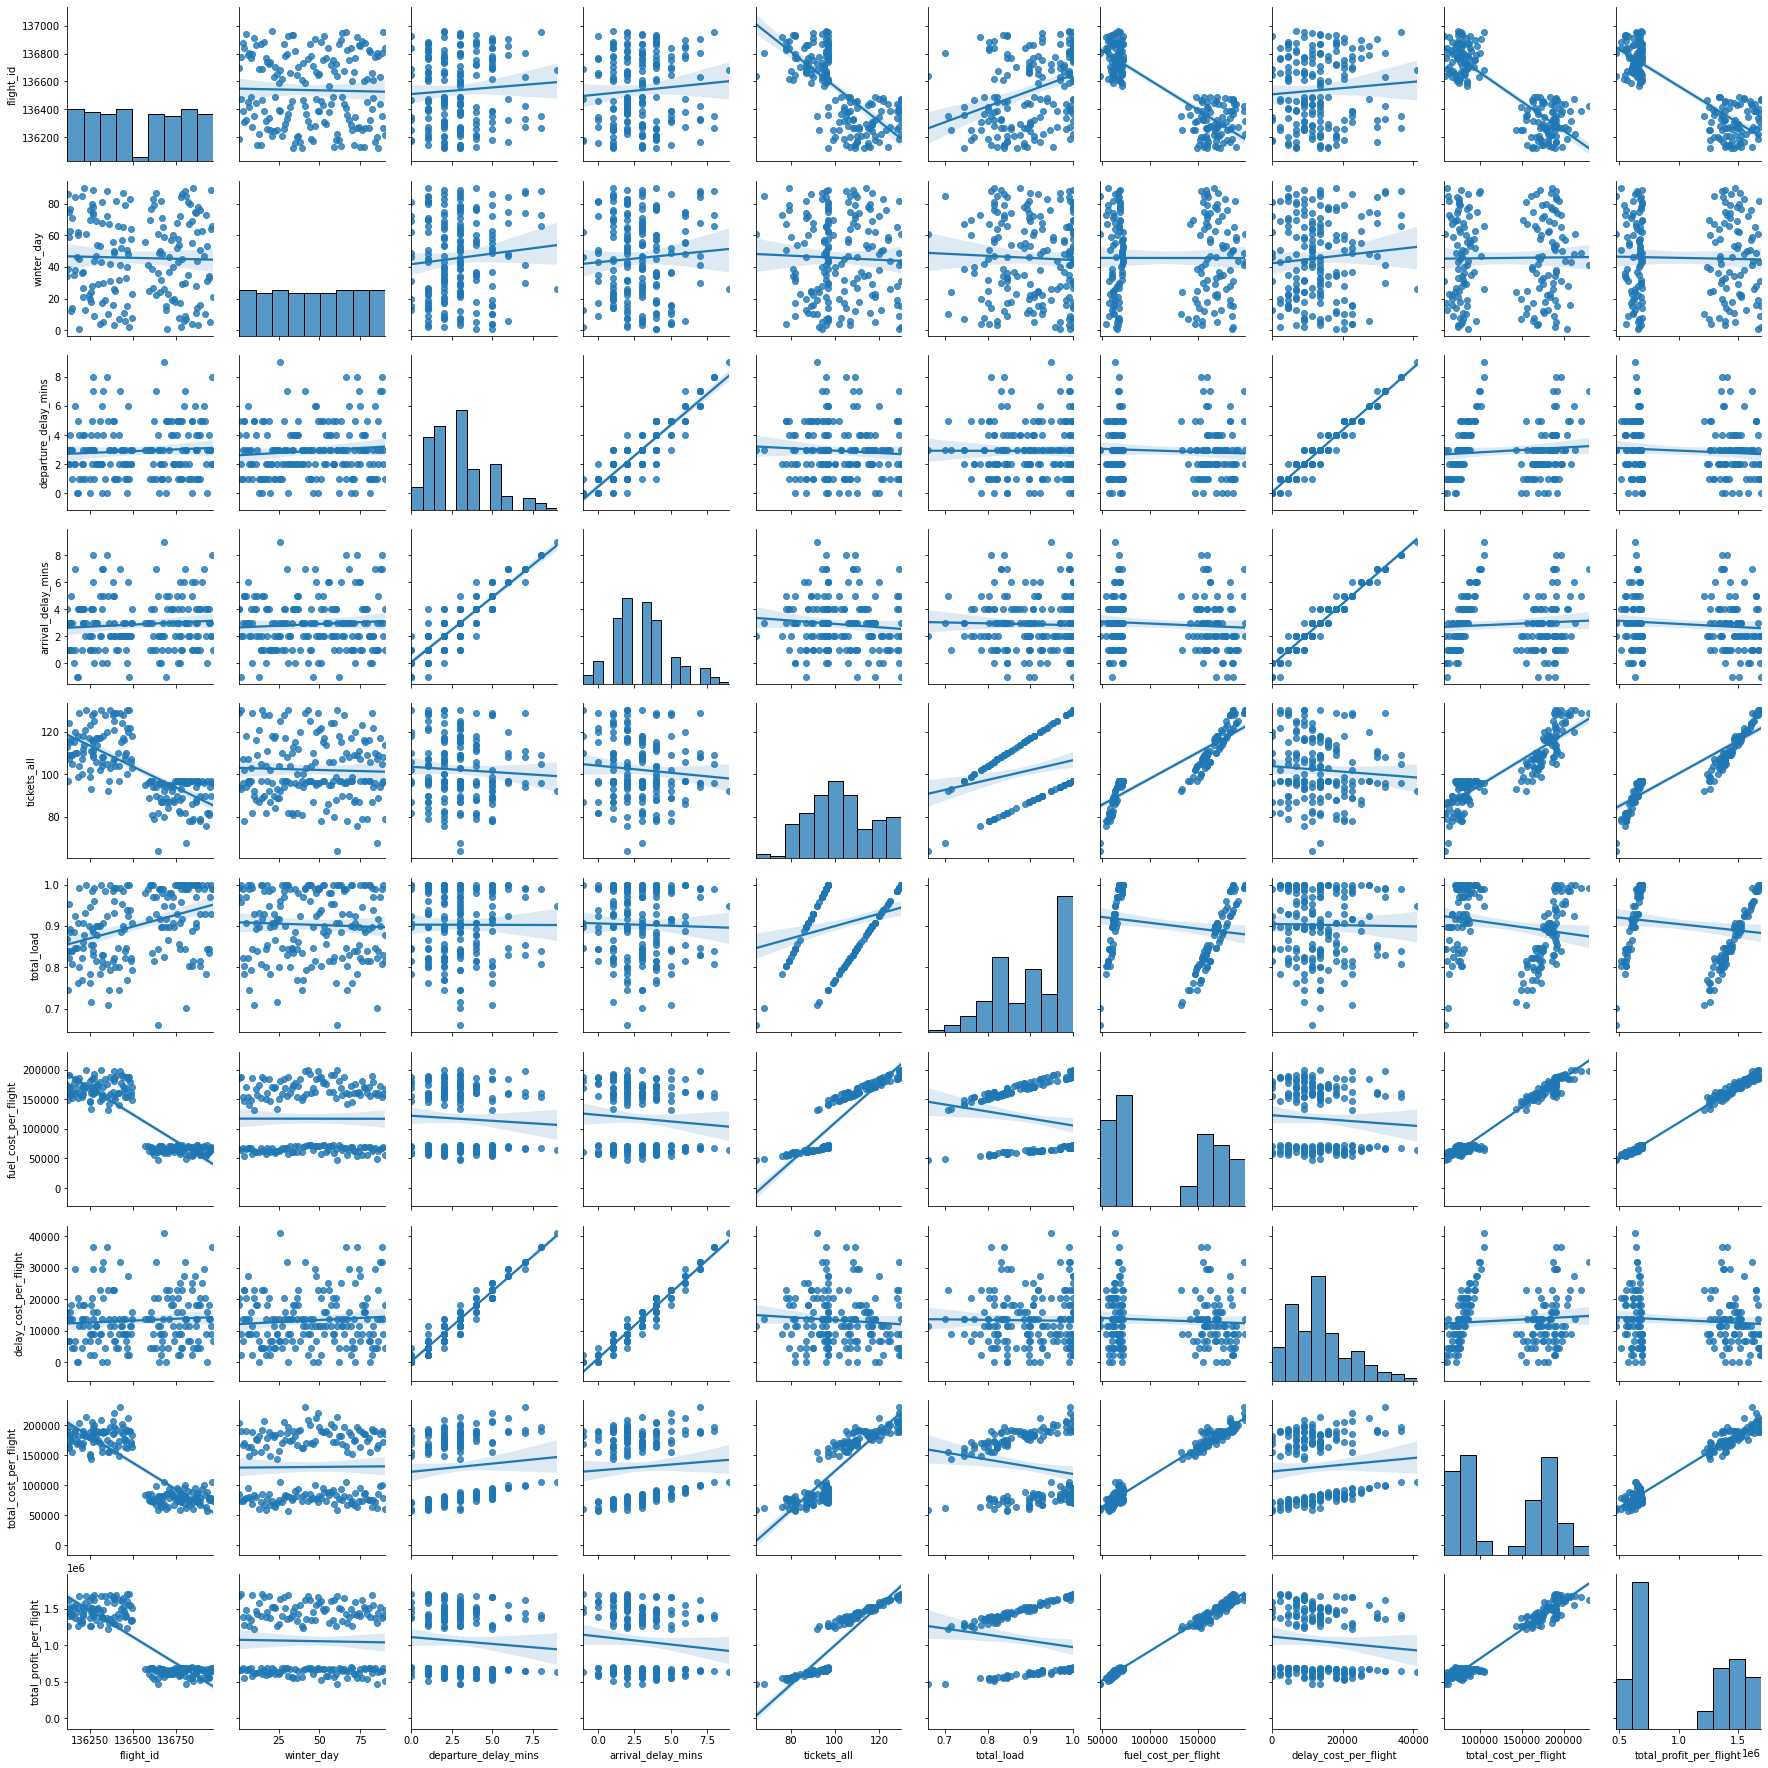

In [59]:
sns.pairplot(dataset, kind='reg')

## 14. Сравнения за один рейс по маркам самолётов 

### 14.1 Прибыль

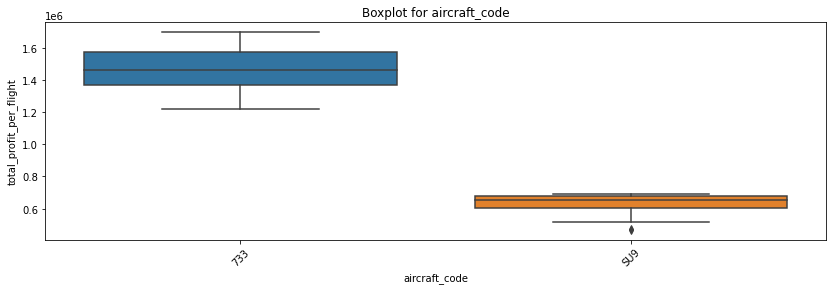

In [60]:
get_boxplot(dataset, "aircraft_code", dataset.total_profit_per_flight)

### 14.2 Затраты

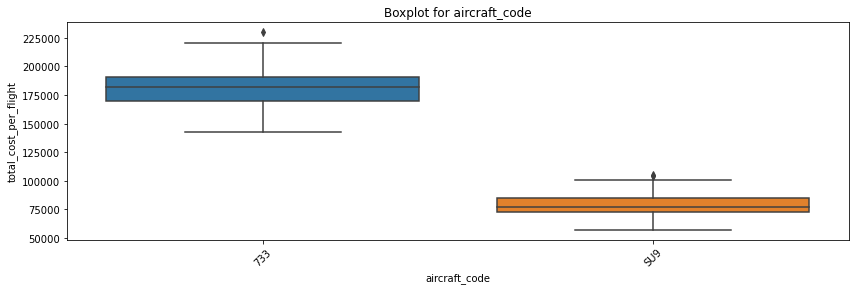

In [61]:
get_boxplot(dataset, "aircraft_code", dataset.total_cost_per_flight)

### 14.3 Загруженность в долях

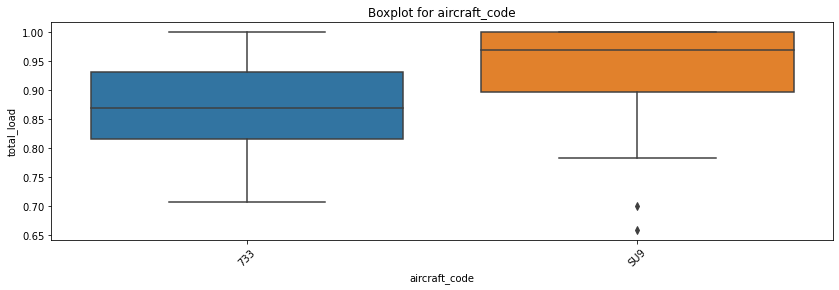

In [62]:
get_boxplot(dataset, "aircraft_code", dataset.total_load)

### 14.4 Задержки

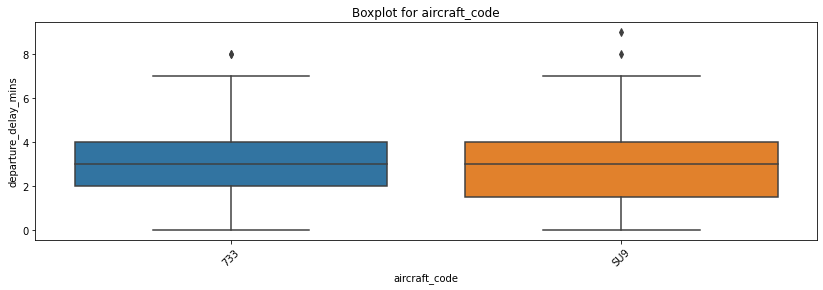

In [63]:
get_boxplot(dataset, "aircraft_code", dataset.departure_delay_mins)

### 14.5 Опоздания

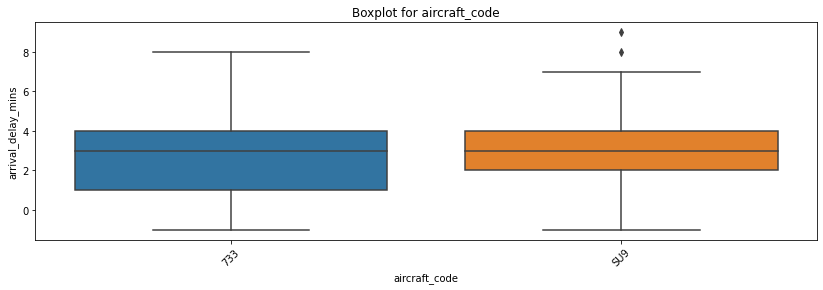

In [64]:
get_boxplot(dataset, "aircraft_code", dataset.arrival_delay_mins)

## 15. Сравнения по временной оси

### 15.1 По месяцам

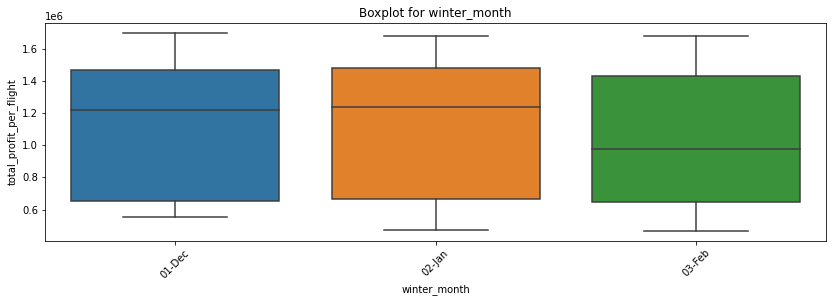

In [65]:
get_boxplot(dataset, "winter_month", dataset.total_profit_per_flight)

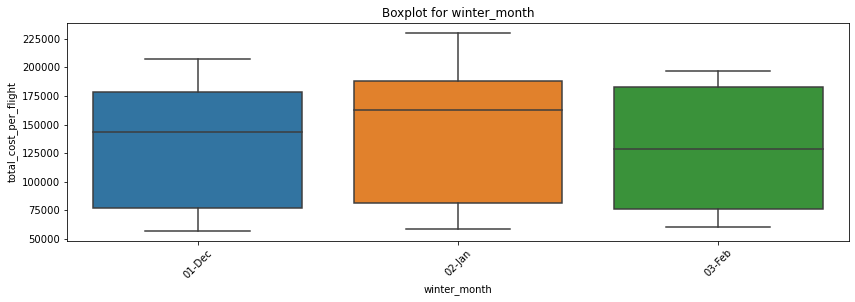

In [66]:
get_boxplot(dataset, "winter_month", dataset.total_cost_per_flight)

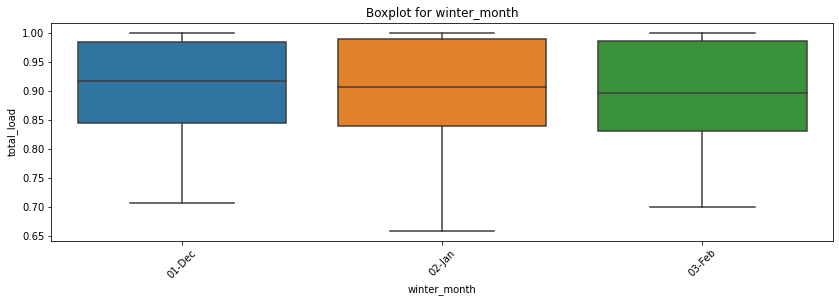

In [67]:
get_boxplot(dataset, "winter_month", dataset.total_load)

#### 15.1.1 По месяцам и самолётам

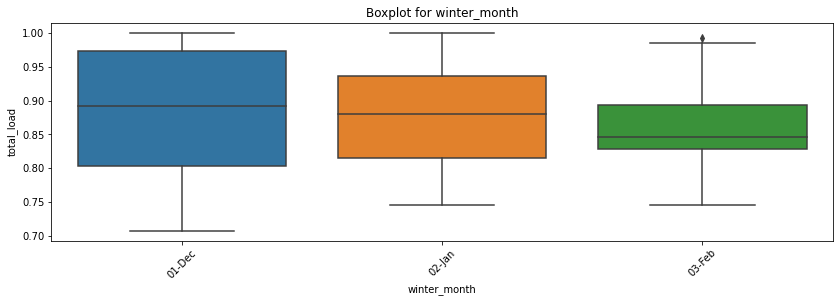

In [68]:
get_boxplot(dataset[dataset.aircraft_code == "733"], "winter_month", dataset.total_load)

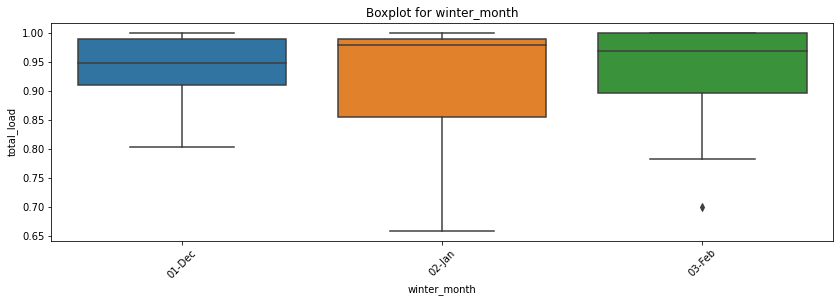

In [69]:
get_boxplot(dataset[dataset.aircraft_code == "SU9"], "winter_month", dataset.total_load)

### 15.2 По дням в зимнее время года

<AxesSubplot:xlabel='winter_day', ylabel='total_cost_per_flight'>

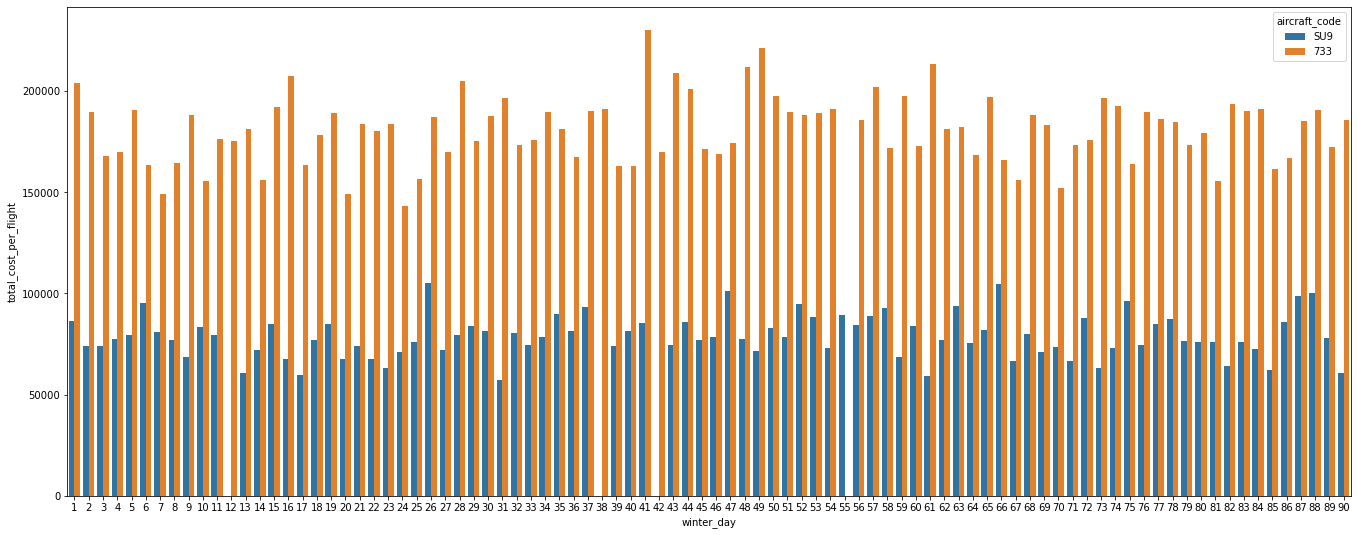

In [70]:
plt_dims = (23, 9)
fig, ax = plt.subplots(figsize=plt_dims)
sns.barplot(x="winter_day", y="total_cost_per_flight", hue="aircraft_code", data=dataset, ax=ax)

## 16. Общие выводы

Из графиков и матрицы коэффициентов корреляции можно сделать ряд предварительных выводов
- Время задержек рейсов время опозданий слабо положительно коррелирует с порядковым номером дня в зимнее время года. То есть чем ближе к концу зимы, тем расходы на задержки рейсов могут быть выше;
- Медианное значение прибыли ниже в феврале, в соответствии с 1-й диаграммой в пункте 15.1;
- Медианное значение относительной загруженности рейса также ниже всего в феврале по 3-й диаграмме пункта 15.1. При этом По первой диаграмме пункта 15.1.1 видно, что снижение загруженности рейса по месяцам спадпет для самолёта Boeing 737-300, а для SSJ-100 меняется мало.
- Из диаграммы в пункте 14.1 видно, что Boeing 737-300 приносим прибыли за рейс намного больше, чем SSJ-100, но при этом по диаграмме загруженности из пункта 14.3 видно, что Boeing 737-300 в среднем загружен меньше, чем SSJ-100. то есть самолёты типа Boeing 737-300 можно было бы использовать более эффективно, если перенести на 737-300 пассажиров с рейсов, где сейчас летает SSJ-100.

<b>Общая рекомендация:</b> перенести пассажирские авиаперевозки с самолётов типа SSJ-100 на самолёты типа Boeing 737-300, чтобы более эффективно использовать более прибыльный самолёт; оптимизировать (уменьшить) колическтво рейсов в феврале месяце так, чтобы повысить загруженность самолётов и эффективно уменьшить расходы на задержки рейсов в аэропортах к концу зимнего периода.

In [71]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 13 to 192
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   flight_id                176 non-null    float64       
 1   departure_airport        176 non-null    object        
 2   arrival_airport          176 non-null    object        
 3   winter_day               176 non-null    int64         
 4   winter_month             176 non-null    object        
 5   actual_departure         176 non-null    datetime64[ns]
 6   actual_arrival           176 non-null    datetime64[ns]
 7   departure_delay_mins     176 non-null    float64       
 8   arrival_delay_mins       176 non-null    float64       
 9   tickets_all              176 non-null    float64       
 10  total_load               176 non-null    float64       
 11  fuel_cost_per_flight     176 non-null    float64       
 12  delay_cost_per_flight    176 non-nu

In [72]:
dataset.to_csv("final_dataset_2016_2017.csv", index=False)